In [1]:
import numpy as np
import sys,os,glob
ia898path = os.path.abspath('/home/lotufo')
if ia898path not in sys.path:
    sys.path.append(ia898path)
import ia898.src as ia

%matplotlib inline
import matplotlib.image as mpimg

In [2]:
import os
fpath = '/awmedia3/db1_a/'
d = os.listdir(fpath)
print('arquivos:',len(d))

arquivos: 801


In [3]:
list0 = glob.glob(fpath+'21_*.tif')
print(len(list0))
print(list0)

8
['/awmedia3/db1_a/21_1.tif', '/awmedia3/db1_a/21_3.tif', '/awmedia3/db1_a/21_7.tif', '/awmedia3/db1_a/21_4.tif', '/awmedia3/db1_a/21_5.tif', '/awmedia3/db1_a/21_8.tif', '/awmedia3/db1_a/21_2.tif', '/awmedia3/db1_a/21_6.tif']


# Leitura de dois fingerprints para fazer o primeiro teste

""
f
""
f1

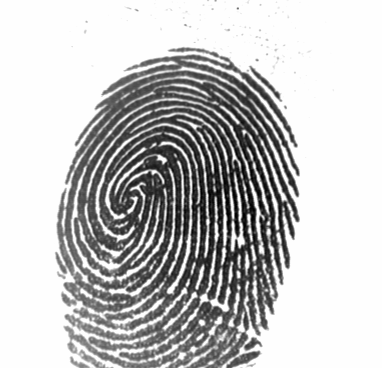
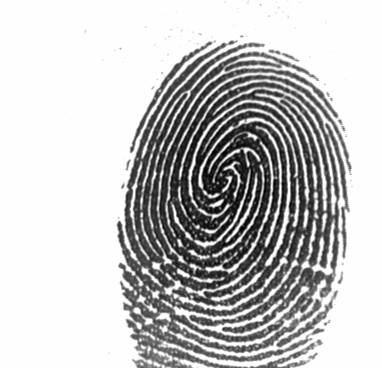

In [4]:
f = mpimg.imread('/awmedia3/db1_a/21_1.tif')
f1 = mpimg.imread('/awmedia3/db1_a/21_3.tif')
f = f[3:-3,3:-3]
f1 = f1[3:-3,3:-3]

nb = ia.nbshow(2)
nb.nbshow(f,'f')
nb.nbshow(f1,'f1')
nb.nbshow()
                  

## Identificação do ângulo de rotação

### Calcular a transformada polar da visualização da DFT

""
F
""
F1

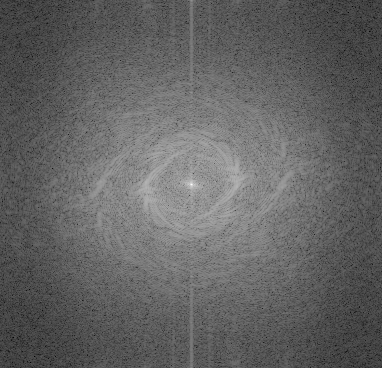
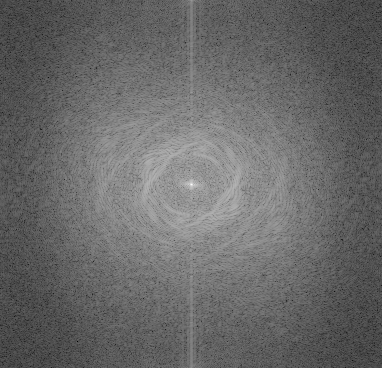

""
polar Fp
""
polar F1p

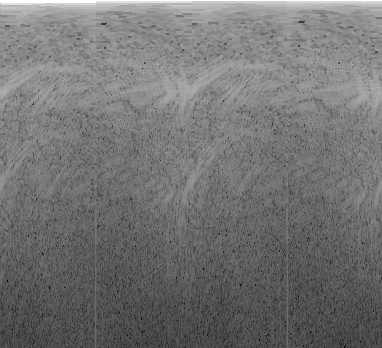
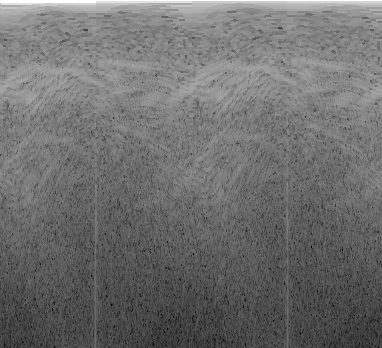

In [12]:
F = np.fft.fft2(f)
F1 = np.fft.fft2(f1)

#nb = ia.nbshow(2)
#nb.nbshow(ia.dftview(F),'F')
#nb.nbshow(ia.dftview(F1),'F1')
#nb.nbshow()

F = ia.dftview(F)
F1 = ia.dftview(F1)

#H,W = F.shape
#U,V = (120,120)

#F = F[H//2-U:H//2+U,W//2-V:W//2+V]
#F1 = F1[H//2-U:H//2+U,W//2-V:W//2+V]

nb = ia.nbshow(2)
nb.nbshow(F,'F')
nb.nbshow(F1,'F1')
nb.nbshow()

Fp = ia.polar(F,F.shape)
F1p = ia.polar(F1,F1.shape)

Fp = Fp[0:-20,:]
F1p = F1p[0:-20,:]

nb = ia.nbshow(2)
nb.nbshow(ia.normalize(Fp),'polar Fp')
nb.nbshow(ia.normalize(F1p),'polar F1p')
nb.nbshow()

### Correlação de fase entre as polares dos espectros para identificar o ângulo de rotação

In [13]:
Pc = ia.phasecorr(Fp,F1p)
peak = np.unravel_index(np.argmax(Pc), Pc.shape)
ang = (float(peak[1])/Pc.shape[1])*360
print('angle:',ang)

angle: 2.827225130890052


## Corrigir a rotação

""
f
""
f1
""
f1 com correção de rotação

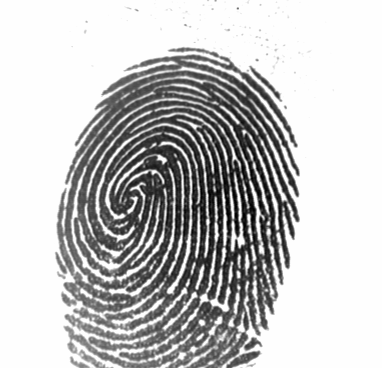
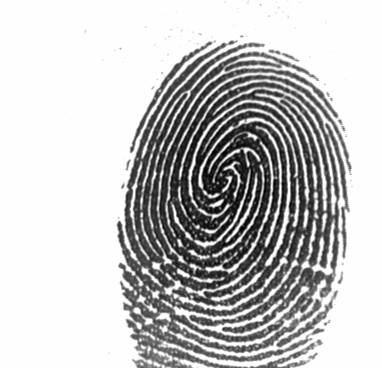
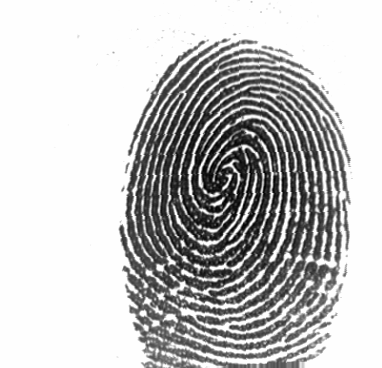

In [14]:
t1 = np.array([
            [1,0,-f1.shape[0]/2.],
            [0,1,-f1.shape[1]/2.],
            [0,0,1]]);

t2 = np.array([
            [1,0,f1.shape[0]/2.],
            [0,1,f1.shape[1]/2.],
            [0,0,1]]);
theta = np.radians(ang)
r1 = np.array([
        [np.cos(theta),-np.sin(theta),0],
        [np.sin(theta),np.cos(theta),0],
        [0,0,1]]);

T = t2.dot(r1).dot(t1)
f1c = ia.affine(f1,T,0)

nb = ia.nbshow(3)
nb.nbshow(f, "f")
nb.nbshow(f1, "f1")
nb.nbshow(f1c, "f1 com correção de rotação")
nb.nbshow()

## Correlação de fase para estimar o deslocamento e a correlação entre as imagens

deslocamento: [356  91]
correlação: 0.0187545882835


""
""
""
""
""
""

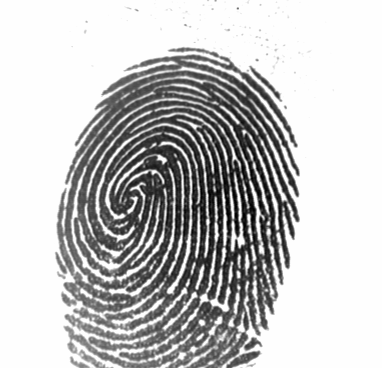
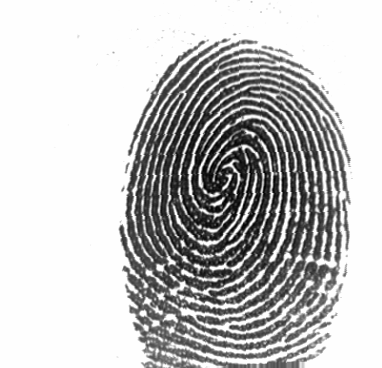
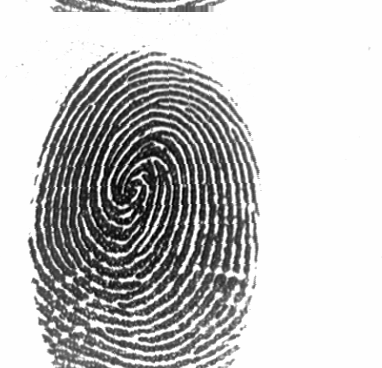

In [15]:
g = ia.phasecorr(f,f1c)

idx = np.argmax(g)
row,col = np.unravel_index(idx,g.shape)
vx = g[row,col]

t = np.array(f.shape) - np.array((row,col))
print('deslocamento:',np.array(f.shape) - np.array((row,col)))
print('correlação:',vx)

f1rt = ia.ptrans(f1c,-t)

nb = ia.nbshow(3)
nb.nbshow(f)
nb.nbshow(f1c)
nb.nbshow(f1rt)
nb.nbshow()

## Corrigir a translação e sobrepor as duas imagens para verificar se a implementação está funcionando

Existem várias formas de sobrepor as duas imagens para uma melhor visualização:
- ponderar cada uma
- combinação no canal de cores, Red, Green, por exemplo
- combinação geométria (linhas pares e impares ou na forma de xadrez)
- ou exclusivo abs(f-f1)

""
Sobreposição ponderada
""
Sobreposição geométrica
""
Combinação no canais Red e Blue

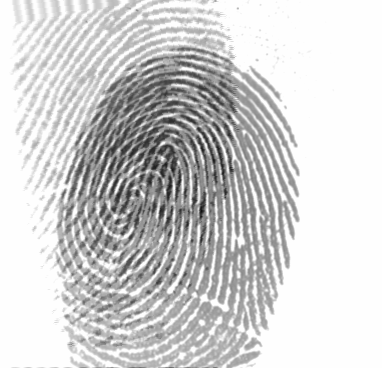
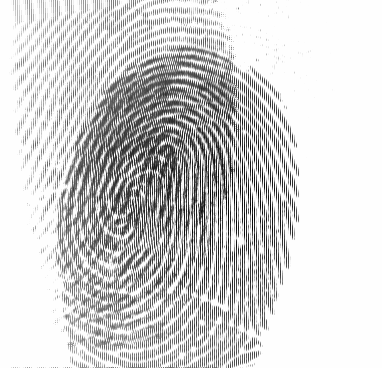
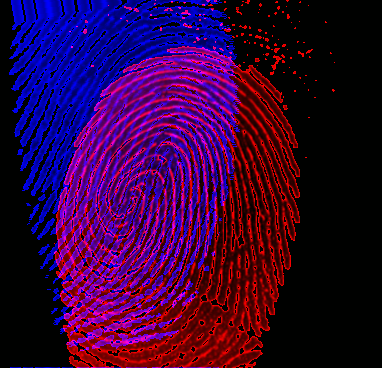

In [294]:
fs1 = (f//2+f1rt//2)

fs2 = np.zeros_like(fs1)
fs2[:,::2] = f[:,::2] 
fs2[:,1::2] = f1rt[:,1::2]

fs3 = np.zeros((f.shape[0],f.shape[1],3))
fs3[:,:,0] = f
fs3[:,:,2] = f1rt
fs3 = fs3.astype(np.uint8)
fs3 = ia.normalize(fs3) - 255 

nb = ia.nbshow(3)
nb.nbshow(fs1,'Sobreposição ponderada')
nb.nbshow(fs2,'Sobreposição geométrica')
nb.nbshow(fs3,'Combinação no canais Red e Blue')
nb.nbshow()


# Aplicar no dataset

## Fazer função v  = fp_match(f,f1)

In [296]:
def fp_match(f, f1):
    # DFT das imagens
    F = np.fft.fft2(f)
    F1 = np.fft.fft2(f1)
    
    # Idetificação do ângulo de rotação
    F = ia.dftview(F)
    F1 = ia.dftview(F1)
    
    Fp = ia.polar(F,F.shape)
    F1p = ia.polar(F1,F1.shape)
    
    Pc = ia.phasecorr(Fp,F1p)
    peak = np.unravel_index(np.argmax(Pc), Pc.shape)
    ang = (float(peak[1])/Pc.shape[1])*360
    
    #Correção de rotação
    t1 = np.array([
            [1,0,-f1.shape[0]/2.],
            [0,1,-f1.shape[1]/2.],
            [0,0,1]]);

    t2 = np.array([
                [1,0,f1.shape[0]/2.],
                [0,1,f1.shape[1]/2.],
                [0,0,1]]);

    theta = np.radians(ang)
    r1 = np.array([
            [np.cos(theta),-np.sin(theta),0],
            [np.sin(theta),np.cos(theta),0],
            [0,0,1]]);

    T = t2.dot(r1).dot(t1)
    f1c = ia.affine(f1,T,0)
    
    #Máxima correlação eentre f e f1
    g = ia.phasecorr(f,f1c)
    idx = np.argmax(g)
    row,col = np.unravel_index(idx,g.shape)
    t = np.array(f.shape) - np.array((row,col))
    f1rt = ia.ptrans(f1c,-t)
    
    return [g[row,col],f1rt]  
    
    

## Sugestão de pegar 3 dedos de 3 pessoas diferentes e comparar tudo com tudo

Pode ser criada uma matriz simétrica do resultado da comparação e visulizá-la na forma de imagem. Quanto maior a correlação, mais claro o valor do elemento da matriz.

In [297]:
import itertools

np.set_printoptions(precision=4)

f1 = mpimg.imread('/awmedia3/db1_a/53_1.tif')
f2 = mpimg.imread('/awmedia3/db1_a/53_4.tif')
f3 = mpimg.imread('/awmedia3/db1_a/53_7.tif')
f4 = mpimg.imread('/awmedia3/db1_a/11_2.tif')
f5 = mpimg.imread('/awmedia3/db1_a/11_5.tif')
f6 = mpimg.imread('/awmedia3/db1_a/11_8.tif')
f7 = mpimg.imread('/awmedia3/db1_a/7_2.tif')
f8 = mpimg.imread('/awmedia3/db1_a/7_3.tif')
f9 = mpimg.imread('/awmedia3/db1_a/7_6.tif')

f1 = f1[3:-3,3:-3]
f2 = f2[3:-3,3:-3]
f3 = f3[3:-3,3:-3]
f4 = f4[3:-3,3:-3]
f5 = f5[3:-3,3:-3]
f6 = f6[3:-3,3:-3]
f7 = f7[3:-3,3:-3]
f8 = f8[3:-3,3:-3]
f9 = f9[3:-3,3:-3]


imgList=[]
nameList=['53_1','53_4','53_7','11_2','11_5','11_8','7_2','7_3','7_6']

imgList.append(f1)
imgList.append(f2)
imgList.append(f3)
imgList.append(f4)
imgList.append(f5)
imgList.append(f6)
imgList.append(f7)
imgList.append(f8)
imgList.append(f9)

idxList = np.arange(9).tolist()
confMat = np.eye(len(idxList))
for idx1,idx2 in itertools.product(idxList, repeat=2):
#for idx1,idx2 in itertools.combinations(idxList, 2):    
    [v,_] = fp_match(imgList[idx1], imgList[idx2])
    confMat[idx1][idx2] = v
    #confMat[idx2][idx1] = confMat[idx1][idx2]    

print('Matriz de confusão:\n',confMat)

Matriz de confusão:
 [[ 1.      0.0481  0.0422  0.014   0.0151  0.0159  0.0142  0.0168  0.015 ]
 [ 0.0481  1.      0.0265  0.0145  0.0157  0.0149  0.0167  0.0137  0.0162]
 [ 0.0422  0.0265  1.      0.015   0.014   0.0155  0.0144  0.015   0.0174]
 [ 0.014   0.0136  0.0159  1.      0.0155  0.0138  0.0153  0.0135  0.0136]
 [ 0.0153  0.0157  0.0138  0.0165  1.      0.0166  0.0156  0.0142  0.015 ]
 [ 0.0159  0.0142  0.0169  0.0151  0.0159  1.      0.015   0.015   0.0132]
 [ 0.0144  0.0138  0.0144  0.0153  0.0142  0.015   1.      0.0158  0.0176]
 [ 0.0168  0.0209  0.015   0.0129  0.0126  0.014   0.0152  1.      0.0138]
 [ 0.0125  0.0162  0.0174  0.0132  0.015   0.0145  0.0176  0.0141  1.    ]]


Melhor correlação de cada linha:
 [1 0 0 4 5 4 8 0 6]


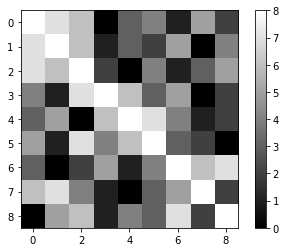

In [298]:
import matplotlib.pyplot as plt

idx = np.argsort(confMat,axis=1)
R,C = np.indices(confMat.shape)
M = np.copy(confMat)
M[R,idx]=C

plt.figure()
plt.imshow(M,cmap='gray')
plt.colorbar()

M = np.copy(confMat)
M[M >= 0.999999999]=0
fclose = M.argmax(axis=0)
print('Melhor correlação de cada linha:\n',fclose)

""
Imagem de referência: 53_1
""
Melhor match: 53_4
""
Sobreposição das imagens

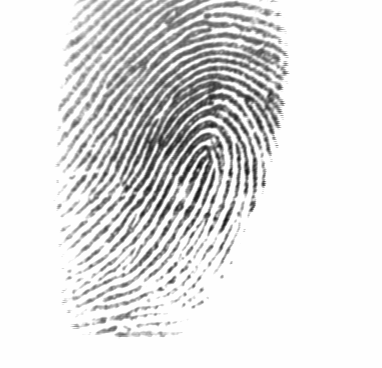
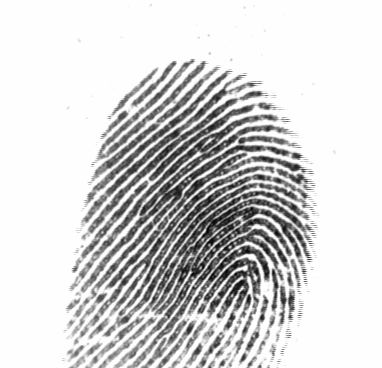
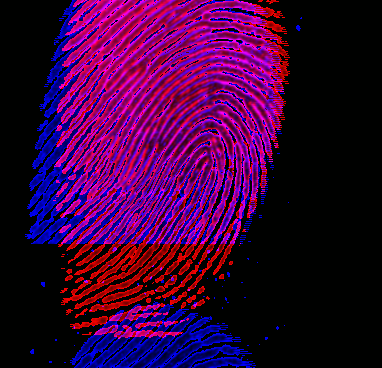

""
Imagem de referência: 53_4
""
Melhor match: 53_1
""
Sobreposição das imagens

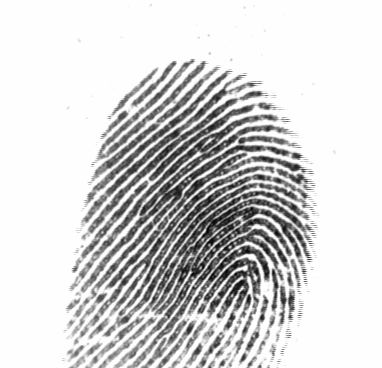
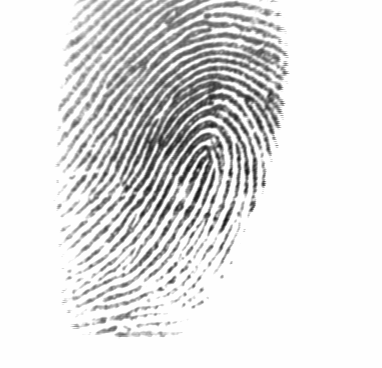
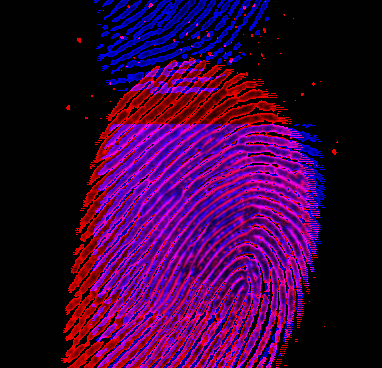

""
Imagem de referência: 53_7
""
Melhor match: 53_1
""
Sobreposição das imagens

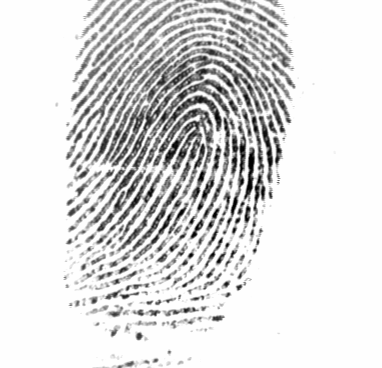
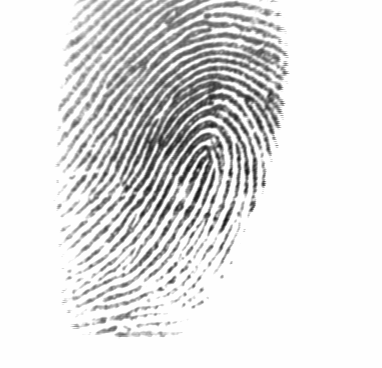
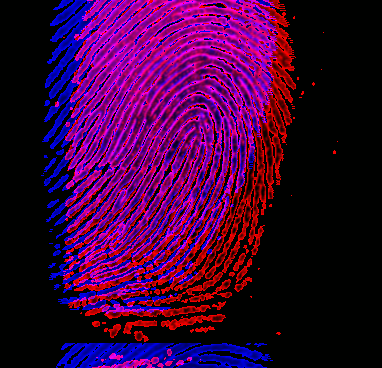

""
Imagem de referência: 11_2
""
Melhor match: 11_5
""
Sobreposição das imagens

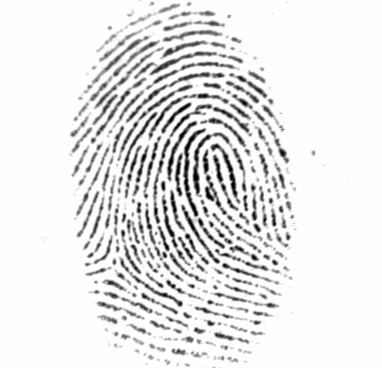
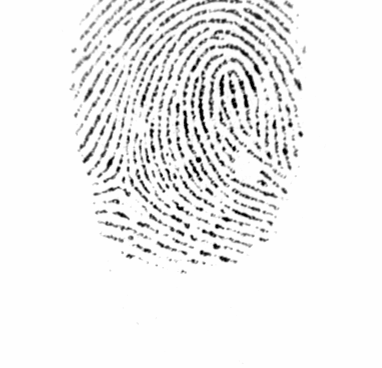
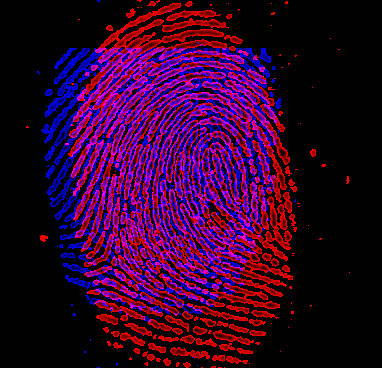

""
Imagem de referência: 11_5
""
Melhor match: 11_8
""
Sobreposição das imagens

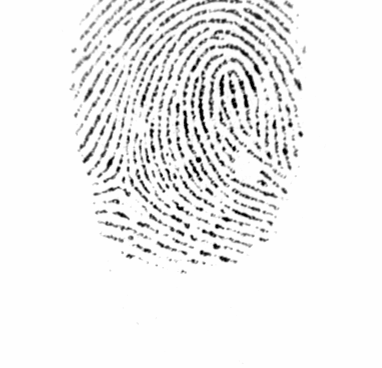
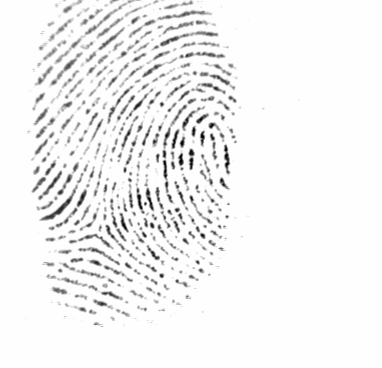
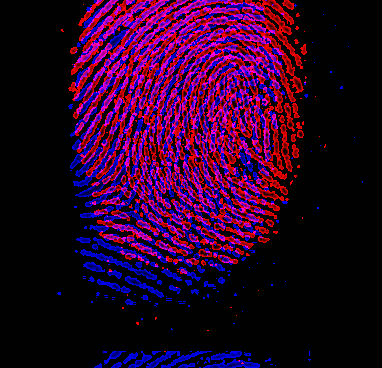

""
Imagem de referência: 11_8
""
Melhor match: 11_5
""
Sobreposição das imagens

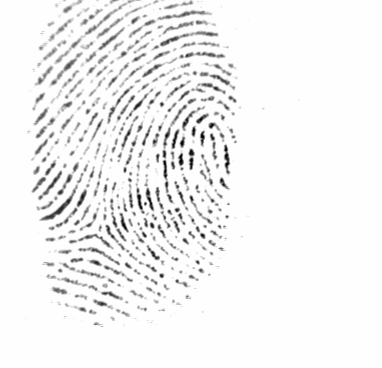
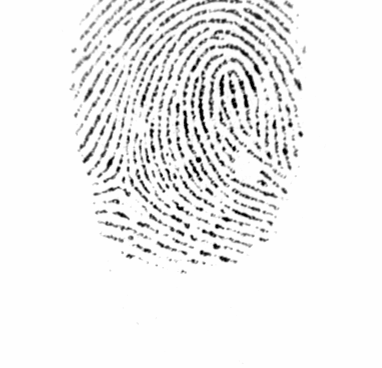
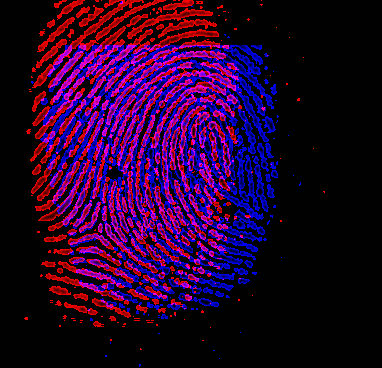

""
Imagem de referência: 7_2
""
Melhor match: 7_6
""
Sobreposição das imagens

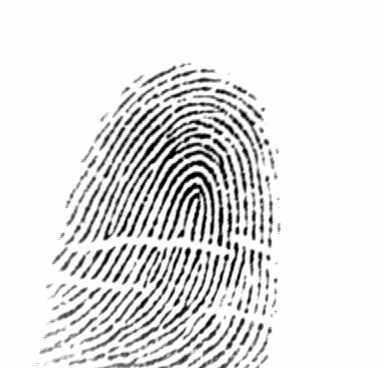
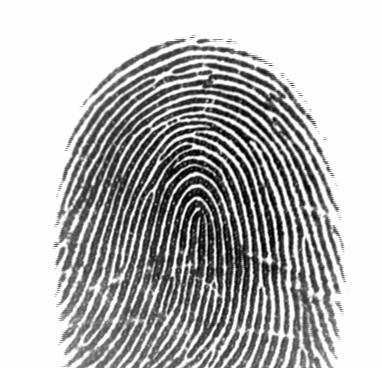
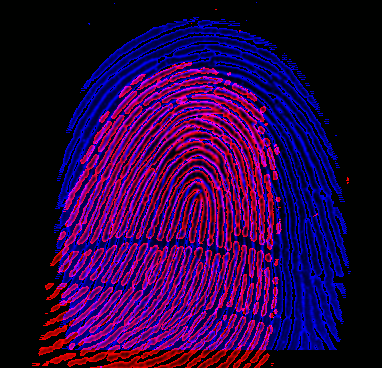

""
Imagem de referência: 7_3
""
Melhor match: 53_1
""
Sobreposição das imagens

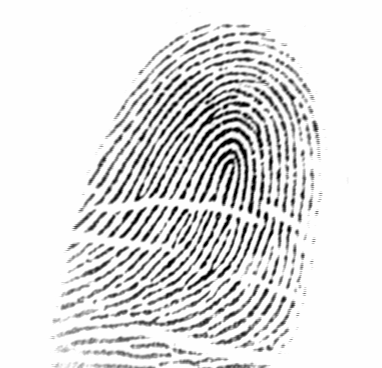
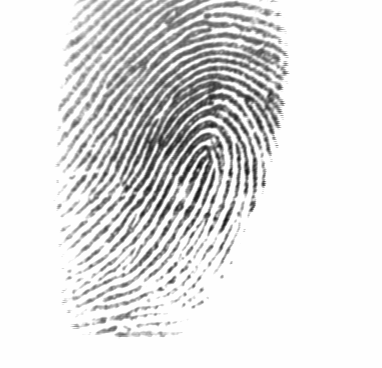
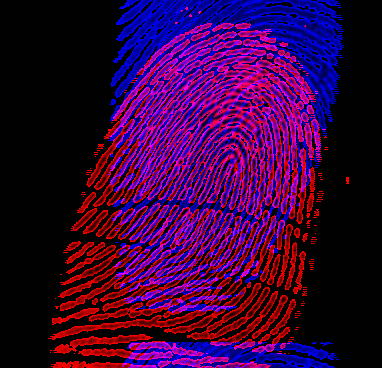

""
Imagem de referência: 7_6
""
Melhor match: 7_2
""
Sobreposição das imagens

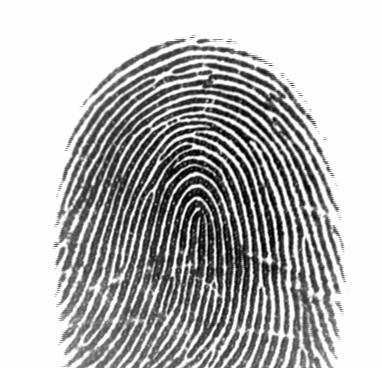
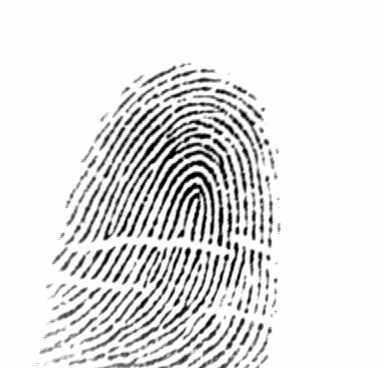
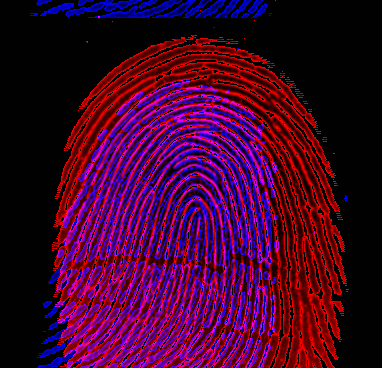

In [299]:
# Melhor resultado para cada imagem
combImg = np.zeros((imgList[0].shape[0],imgList[0].shape[1],3))
    
for i in range(0,9):
    [_,fout] = fp_match(imgList[i], imgList[fclose[i]])
    combImg[:,:,0] = imgList[i]
    combImg[:,:,2] = fout
    combImg = combImg.astype(np.uint8)
    combImg = ia.normalize(combImg) - 255 
    nb = ia.nbshow(3)
    nb.nbshow(imgList[i],'Imagem de referência: %s'%(nameList[i]))
    nb.nbshow(imgList[fclose[i]],'Melhor match: %s'%(nameList[fclose[i]]))
    nb.nbshow(combImg,'Sobreposição das imagens')
    nb.nbshow()
